# Bitcoin Real-Time Analysis Example with Snowflake

This notebook demonstrates an **end-to-end use case** of ingesting real-time Bitcoin prices using the CoinGecko API and storing them into Snowflake. It uses utility functions built in `bitcoin_utils.py` and showcases:

- Data ingestion using Python
- Logging data to Snowflake warehouse
- Real-time analytics: moving averages and volatility
- Visualization of Bitcoin price trends

> See the [Bitcoin.example.md](Bitcoin.example.md) for full project context.


## 1. Setup

### 1.1 Install Required Libraries
Install all necessary dependencies required to connect with Snowflake, call APIs, handle data, and visualize results.


In [5]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
!pip install snowflake-connector-python requests pandas matplotlib plotly python-dotenv


### 1.2 Configure Logger and Environment & Connect to Snowflake
We use `dotenv` to securely load credentials and logging to track key actions.
Create a secure connection to your Snowflake data warehouse.

In [6]:
import os
from dotenv import load_dotenv
import logging

from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import snowflake.connector

# Load environment variables from .env
load_dotenv()

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
load_dotenv()
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("User:", os.getenv("SNOWFLAKE_USER"))
print("Account:", os.getenv("SNOWFLAKE_ACCOUNT"))



User: PWADHWA
Account: RQSQUOH-VVC78987


## Configuration

In [10]:
print("User:", os.getenv("SNOWFLAKE_USER"))
print("Password:", os.getenv("SNOWFLAKE_PASSWORD"))
print("Account:", os.getenv("SNOWFLAKE_ACCOUNT"))
print("Warehouse:", os.getenv("SNOWFLAKE_WAREHOUSE"))
print("Database:", os.getenv("SNOWFLAKE_DATABASE"))
print("Schema:", os.getenv("SNOWFLAKE_SCHEMA"))


User: PWADHWA
Password: Palakwadhwa@202003
Account: RQSQUOH-VVC78987
Warehouse: COMPUTE_WH
Database: BITCOIN_DB
Schema: PUBLIC


NameError: name 'connect_to_snowflake' is not defined

In [16]:
def create_btc_table(conn):
    """
    Create a table in Snowflake to store timestamped Bitcoin price data.
    """
    create_stmt = """
    CREATE TABLE IF NOT EXISTS BTC_PRICES (
        timestamp TIMESTAMP,
        price_usd FLOAT
    );
    """
    conn.cursor().execute(create_stmt)
    logger.info("✅ Table BTC_PRICES is ready.")

create_btc_table(conn)


INFO:snowflake.connector.cursor:query: [CREATE TABLE IF NOT EXISTS BTC_PRICES ( timestamp TIMESTAMP, price_usd FLOAT );]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:✅ Table BTC_PRICES is ready.


In [15]:
def connect_to_snowflake():
    """
    Connect to Snowflake using credentials from .env file.
    """
    conn = snowflake.connector.connect(
        user=os.getenv("SNOWFLAKE_USER"),
        password=os.getenv("SNOWFLAKE_PASSWORD"),
        account=os.getenv("SNOWFLAKE_ACCOUNT"),
        warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
        database=os.getenv("SNOWFLAKE_DATABASE"),
        schema=os.getenv("SNOWFLAKE_SCHEMA")
    )
    logger.info("✅ Connected to Snowflake")
    return conn

# Connect
conn = connect_to_snowflake()


INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.4, Platform: Windows-10-10.0.26100-SP0
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:Setting use_openssl_only mode to False
INFO:__main__:✅ Connected to Snowflake


In [17]:
conn.cursor().execute("USE DATABASE BITCOIN_DB")
conn.cursor().execute("USE SCHEMA PUBLIC")



INFO:snowflake.connector.cursor:query: [USE DATABASE BITCOIN_DB]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [USE SCHEMA PUBLIC]
INFO:snowflake.connector.cursor:query execution done


### 2.2 Create Storage Table
Prepare a table that stores the timestamp and price.


In [18]:
def create_btc_table(conn):
    create_stmt = """
    CREATE TABLE IF NOT EXISTS BTC_PRICES (
        timestamp TIMESTAMP,
        price_usd FLOAT
    );
    """
    conn.cursor().execute(create_stmt)
    logger.info("✅ Table BTC_PRICES is ready.")

# Call the function
create_btc_table(conn)


INFO:snowflake.connector.cursor:query: [CREATE TABLE IF NOT EXISTS BTC_PRICES ( timestamp TIMESTAMP, price_usd FLOAT );]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:✅ Table BTC_PRICES is ready.


## 3. Compute & Clean Data

### 3.1 Fetch Real-time Price
Make a GET request to CoinGecko API and extract the current BTC/USD price.


In [22]:
import requests

def fetch_bitcoin_price():
    """
    Fetch the latest Bitcoin price in USD from CoinGecko API.
    """
    url = "https://api.coingecko.com/api/v3/simple/price"
    params = {"ids": "bitcoin", "vs_currencies": "usd"}
    response = requests.get(url, params=params)
    response.raise_for_status()
    price = response.json()["bitcoin"]["usd"]
    logger.info(f"💰 Current Bitcoin Price: ${price}")
    return price

# Fetch and print
btc_price = fetch_bitcoin_price()
print("Fetched price:", btc_price)


INFO:__main__:💰 Current Bitcoin Price: $103022


Fetched price: 103022


### 3.2 Insert Price to Snowflake
Save the timestamped price into your database table.



In [25]:
from datetime import datetime

def insert_bitcoin_price(conn, price_usd):
    """
    Insert the current timestamp and Bitcoin price into the Snowflake table.
    """
    insert_stmt = """
    INSERT INTO BTC_PRICES (timestamp, price_usd)
    VALUES (%s, %s);
    """
    conn.cursor().execute(insert_stmt, (datetime.utcnow(), price_usd))
    logger.info("📥 Inserted Bitcoin price into Snowflake.")

# Insert latest price
insert_bitcoin_price(conn, btc_price)
def fetch_btc_data(conn):
    """
    Fetch all rows from the BTC_PRICES table in Snowflake.
    
    :param conn: Snowflake connection object
    :return: DataFrame containing timestamped Bitcoin prices
    """
    import pandas as pd
    query = "SELECT * FROM BTC_PRICES ORDER BY timestamp ASC;"
    df = pd.read_sql(query, conn)
    return df


INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:35:56.98157...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


## 4. Logging Loop (Collect More Data)
Record prices at 10-second intervals to simulate real-time streaming.

In [26]:
import time
import matplotlib.pyplot as plt

# Loop to collect 5 prices at 10-second intervals
for i in range(5):
    btc_price = fetch_bitcoin_price()  # Fetch live price
    insert_bitcoin_price(conn, btc_price)  # Insert into Snowflake
    print(f"[{i+1}] Inserted price: {btc_price}")
    time.sleep(10)  

# Fetch data back from Snowflake
btc_df = fetch_btc_data(conn)

# Display last few rows
print(btc_df)





INFO:__main__:💰 Current Bitcoin Price: $102936
INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:37:33.75602...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


[1] Inserted price: 102936


INFO:__main__:💰 Current Bitcoin Price: $102936
INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:37:44.40282...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


[2] Inserted price: 102936


INFO:__main__:💰 Current Bitcoin Price: $102936
INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:37:55.17362...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


[3] Inserted price: 102936


INFO:__main__:💰 Current Bitcoin Price: $102936
INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:38:05.88555...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


[4] Inserted price: 102936


INFO:__main__:💰 Current Bitcoin Price: $102933
INFO:snowflake.connector.cursor:query: [INSERT INTO BTC_PRICES (timestamp, price_usd) VALUES ('2025-05-17 01:38:16.71990...]
INFO:snowflake.connector.cursor:query execution done
INFO:__main__:📥 Inserted Bitcoin price into Snowflake.


[5] Inserted price: 102933


INFO:snowflake.connector.cursor:query: [SELECT * FROM BTC_PRICES ORDER BY timestamp ASC;]
INFO:snowflake.connector.cursor:query execution done


                    TIMESTAMP  PRICE_USD
0  2025-05-06 13:13:41.253096    93784.0
1  2025-05-06 13:24:33.290388    93784.0
2  2025-05-06 13:25:58.125975    93788.0
3  2025-05-06 13:26:08.742683    93788.0
4  2025-05-06 13:26:19.517189    93788.0
5  2025-05-06 13:26:30.297019    93788.0
6  2025-05-06 13:26:40.984126    93788.0
7  2025-05-06 14:06:16.844244    93843.0
8  2025-05-06 14:06:30.734054    93843.0
9  2025-05-06 14:06:41.544950    93880.0
10 2025-05-06 14:06:52.580573    93880.0
11 2025-05-06 14:07:03.494363    93880.0
12 2025-05-06 14:07:42.548931    93909.0
13 2025-05-06 14:07:53.360365    93909.0
14 2025-05-06 14:08:04.069229    93909.0
15 2025-05-06 14:08:14.892224    93909.0
16 2025-05-06 14:08:25.778342    93909.0
17 2025-05-06 14:10:17.507311    93917.0
18 2025-05-06 14:10:28.235739    93917.0
19 2025-05-06 14:10:39.044601    93917.0
20 2025-05-06 14:10:50.030948    93935.0
21 2025-05-06 14:11:00.813729    93935.0
22 2025-05-17 01:27:19.365924   103037.0
23 2025-05-17 01

## 5. Load & Analyze Results
## 5.1 Compute Metrics
Add calculated fields for moving averages and volatility.

In [27]:
# Calculate a 3-point Simple Moving Average
btc_df['SMA_3'] = btc_df['PRICE_USD'].rolling(window=3).mean()

# Calculate rolling standard deviation (volatility)
btc_df['Volatility'] = btc_df['PRICE_USD'].rolling(window=3).std()

# Show latest entries with indicators
print(btc_df)


                    TIMESTAMP  PRICE_USD          SMA_3   Volatility
0  2025-05-06 13:13:41.253096    93784.0            NaN          NaN
1  2025-05-06 13:24:33.290388    93784.0            NaN          NaN
2  2025-05-06 13:25:58.125975    93788.0   93785.333333     2.309401
3  2025-05-06 13:26:08.742683    93788.0   93786.666667     2.309401
4  2025-05-06 13:26:19.517189    93788.0   93788.000000     0.000000
5  2025-05-06 13:26:30.297019    93788.0   93788.000000     0.000000
6  2025-05-06 13:26:40.984126    93788.0   93788.000000     0.000000
7  2025-05-06 14:06:16.844244    93843.0   93806.333333    31.754265
8  2025-05-06 14:06:30.734054    93843.0   93824.666667    31.754265
9  2025-05-06 14:06:41.544950    93880.0   93855.333333    21.361960
10 2025-05-06 14:06:52.580573    93880.0   93867.666667    21.361960
11 2025-05-06 14:07:03.494363    93880.0   93880.000000     0.000073
12 2025-05-06 14:07:42.548931    93909.0   93889.666667    16.743158
13 2025-05-06 14:07:53.360365    9

## 6. Analyze and Show Insights

### 6.1 Plot Trend and Volatility

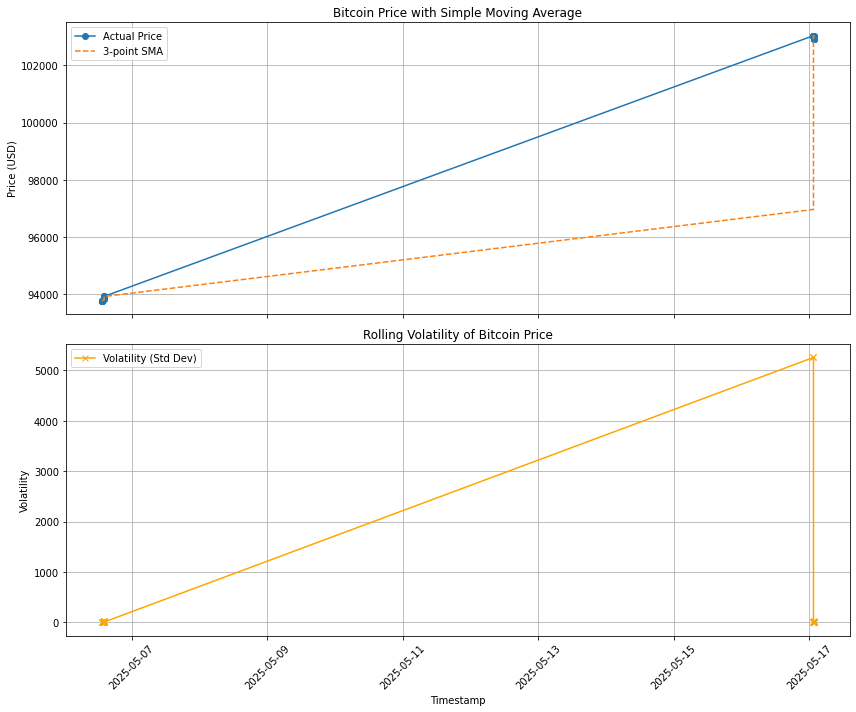

In [28]:
import matplotlib.pyplot as plt

# Ensure latest metrics are visible
btc_df['SMA_3'] = btc_df['PRICE_USD'].rolling(window=3).mean()
btc_df['Volatility'] = btc_df['PRICE_USD'].rolling(window=3).std()

# Set up subplots for price + volatility
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Price + SMA
axs[0].plot(btc_df['TIMESTAMP'], btc_df['PRICE_USD'], label='Actual Price', marker='o')
axs[0].plot(btc_df['TIMESTAMP'], btc_df['SMA_3'], label='3-point SMA', linestyle='--')
axs[0].set_title("Bitcoin Price with Simple Moving Average")
axs[0].set_ylabel("Price (USD)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Volatility
axs[1].plot(btc_df['TIMESTAMP'], btc_df['Volatility'], label='Volatility (Std Dev)', color='orange', marker='x')
axs[1].set_title("Rolling Volatility of Bitcoin Price")
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Volatility")
axs[1].legend()
axs[1].grid(True)

# Format x-axis
plt.xticks(rotation=45)
plt.tight_layout()

# Save the combined plot as PNG
plt.savefig("bitcoin_price_analysis.png", dpi=300)
plt.show()


In [30]:
btc_df['Moving_Avg'] = btc_df['PRICE_USD'].rolling(window=3).mean()
btc_df['Price_Change'] = btc_df['PRICE_USD'].diff()




## Conclusion

This notebook showcased a real-time data ingestion and analysis workflow using Python and Snowflake. We demonstrated how to fetch live Bitcoin prices, store them in Snowflake, and perform rolling analytics like moving averages and volatility computation.


> Notebook written as part of DATA605 Project: TutorTask155_Spring2025  
> For more, see [Bitcoin.example.ipynb](./Bitcoin.example.ipynb) and [Bitcoin.API.md](./Bitcoin.API.md).